In [1]:
# Data
import numpy as np
from sklearn.datasets import make_circles

# Plots
import matplotlib.pyplot as plt
%matplotlib inline  
from matplotlib.colors import ListedColormap

import math
import os # To use the system comands in python
import matplotlib.pyplot as plt # plotting library
import numpy as numpy  #Numerical python liberary
import pandas as pd #Data handeling python module 
plt.style.use('seaborn')
import pennylane as qml 
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

/var/folders/rt/xq48jp6s6dd46d2jc17rhj5m0000gn/T/ipykernel_38500/2363278977.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


### Input data generation

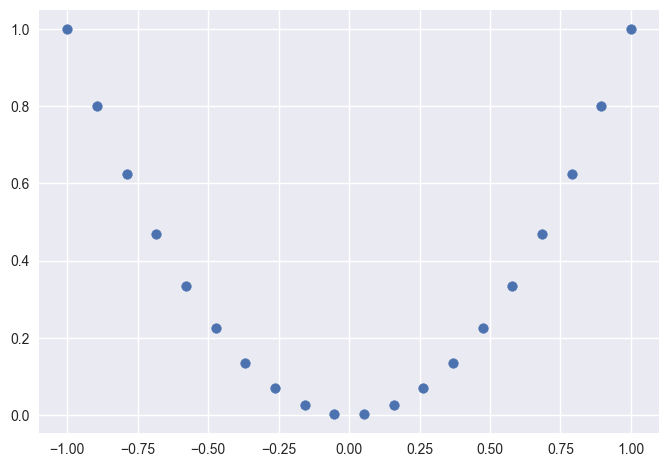

In [18]:
X_range = np.linspace(-1.0,1.0,20)
X_data = np.stack([X_range, (X_range)**2],axis=1)
X_data[:,0]
X = np.array(X_data[:,0], requires_grad=False)
Y = np.array(X_data[:,1], requires_grad=False)
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# plt.scatter(X, y, c=y, cmap=cm_bright, edgecolors='k')
plt.scatter(X,Y)

### Circuit

In [3]:
import itertools
from pennylane.templates import ApproxTimeEvolution

In [4]:
n_qubits = 6
depth = 6

In [5]:
combi = 15
initial_theta = np.random.uniform(0.0, 2*np.pi, size=3*n_qubits*depth)
random_aj = np.random.uniform(-1,1,size=n_qubits)
# random_aj = np.zeros_like(random_aj)
random_jjk = np.random.uniform(-1,1,size=combi)
# random_jjk = np.zeros_like(random_jjk)
coeff_jjk = np.zeros((n_qubits, n_qubits-1))
for j in range(n_qubits):
    for k in range(j):
        coeff_jjk[j,k] = random_jjk[j+k]
# print(coeff_jjk.shape)

In [6]:
coeff_jjk

tensor([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.07258174,  0.        ,  0.        ,  0.        ,  0.        ],
        [-0.54293334,  0.08679548,  0.        ,  0.        ,  0.        ],
        [ 0.08679548,  0.26950609, -0.19617721,  0.        ,  0.        ],
        [ 0.26950609, -0.19617721,  0.94602167,  0.20727361,  0.        ],
        [-0.19617721,  0.94602167,  0.20727361, -0.14846719, -0.89005744]], requires_grad=True)

In [7]:
initial_theta = initial_theta.reshape(3,n_qubits,depth)

In [19]:
dev = qml.device('default.qubit', wires=n_qubits)
# def Uin(x):
#     for xs in x:
#         for j in range(n_qubits):
#             qml.RZ(np.arccos(xs**2), wires=j) * qml.RY(np.arcsin(xs), wires=j)
def Uin(x):
    for j in range(n_qubits):
#         qml.RZ(np.arccos(x**2), wires=j) * qml.RY(np.arcsin(x), wires=j)
        qml.RY(np.arcsin(x), wires=j)

def hamltn(coeffA, coeffJ):
    part1 = 0
    part2 = 0
    for j in range(n_qubits):
        # coeffA[j] * qml.PauliX(j)
        temp1 = coeffA[j] * qml.PauliX(j)
        part1 += temp1

    for j in range(n_qubits):
        for k in range(j):
            # coeffJ[j,k]* qml.PauliZ(j) @ qml.PauliZ(k)
            temp2 = coeffJ[j,k]* qml.PauliZ(j) @ qml.PauliZ(k)
            part2 += temp2

    hamiltonian = part1 + part2
    return hamiltonian


def Uth(theta):
    for i in range(depth):                  
        qml.ApproxTimeEvolution(hamltn(random_aj, coeff_jjk), 10, 1)
        for j in range(n_qubits):
            rj = n_qubits-j-1
            # rj = j
            qml.RX(theta[0,rj,i],wires=j)
            qml.RZ(theta[1,rj,i],wires=j)
            qml.RX(theta[2,rj,i],wires=j)
# RX(phi, wires, do_queue=True, id=None)[source]¶
weights = initial_theta
# # 
@qml.qnode(dev)
def circuit(x,params):
    Uin(x)
    Uth(params)
    return [qml.expval(qml.PauliZ(wires=0))]


print(qml.draw(circuit)(X,weights))


0: ──RY(M0)
1: ──RY(M0)
2: ──RY(M0)
3: ──RY(M0)
4: ──RY(M0)
5: ──RY(M0)

──╭ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──╰ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)

───RX(0.74)──RZ(3.85)──RX(0.62)
───RX(2.97)──RZ(1.70)──R

In [20]:
def quad_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p)**2
#         p = (p + 1)/2
#         loss = loss + (l - p)**2
        
    return loss

def cost(var, features, labels):
    preds = [circuit(x, var) for x in features] 
    
    return quad_loss(labels, preds)


In [21]:
step_size = 0.01
opt = AdamOptimizer(step_size, beta1 = 0.9, beta2=0.99)

var = weights

for it in range(50):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X, Y)
    print("Iter: {:5d}  ".format(it))

Iter:     0  
Iter:     1  
Iter:     2  
Iter:     3  
Iter:     4  
Iter:     5  
Iter:     6  
Iter:     7  
Iter:     8  
Iter:     9  
Iter:    10  
Iter:    11  
Iter:    12  
Iter:    13  
Iter:    14  
Iter:    15  
Iter:    16  
Iter:    17  
Iter:    18  
Iter:    19  
Iter:    20  
Iter:    21  
Iter:    22  
Iter:    23  
Iter:    24  
Iter:    25  
Iter:    26  
Iter:    27  
Iter:    28  
Iter:    29  
Iter:    30  
Iter:    31  
Iter:    32  
Iter:    33  
Iter:    34  
Iter:    35  
Iter:    36  
Iter:    37  
Iter:    38  
Iter:    39  
Iter:    40  
Iter:    41  
Iter:    42  
Iter:    43  
Iter:    44  
Iter:    45  
Iter:    46  
Iter:    47  
Iter:    48  
Iter:    49  


In [22]:
x_pred = np.linspace(-1, 1, 20)
x_init = x_pred.copy()
predictions = [circuit(x_pred, var) for x_ in x_pred]

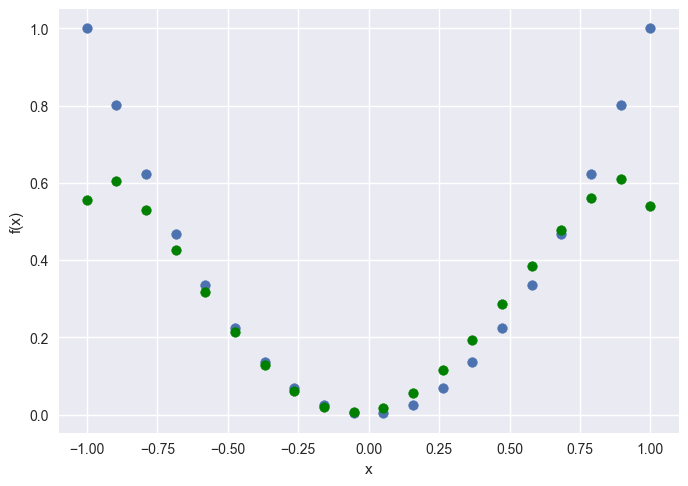

In [33]:
# # x_pred = np.linspace(-1, 1, 20)
# # predictions = [circuit(x_pred, var) for x_ in x_pred]
# savedir = "/Users/soyoung/Documents/works/QC/QCL/qcl/store/"
# plt.figure()
# plt.scatter(X, Y)
# plt.scatter(x_pred, predictions[0], color="green")
# plt.xlabel("x")
# plt.ylabel("f(x)")
# plt.tick_params(axis="both", which="major")
# plt.tick_params(axis="both", which="minor")
# plt.savefig(savedir+"ajk_0.png")
# plt.show()

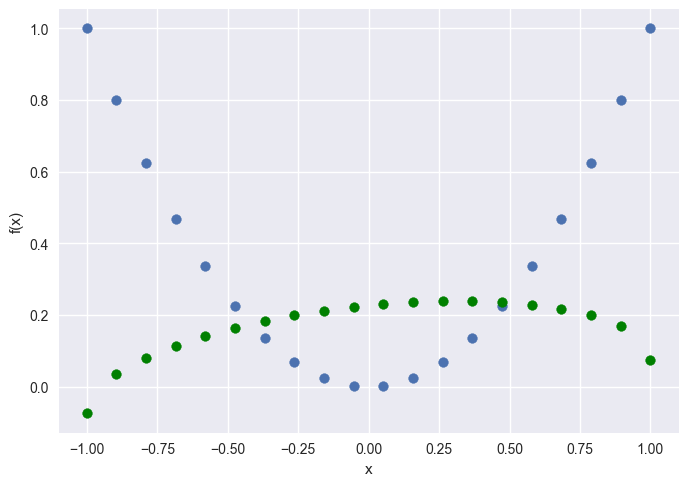

In [42]:
# # x_pred = np.linspace(-1, 1, 20)
# # predictions = [circuit(x_pred, var) for x_ in x_pred]
# savedir = "/Users/soyoung/Documents/works/QC/QCL/qcl/store/"
# plt.figure()
# plt.scatter(X, Y)
# plt.scatter(x_pred, predictions[0], color="green")
# plt.xlabel("x")
# plt.ylabel("f(x)")
# plt.tick_params(axis="both", which="major")
# plt.tick_params(axis="both", which="minor")
# plt.savefig(savedir+"coeffjk_0.png")
# plt.show()

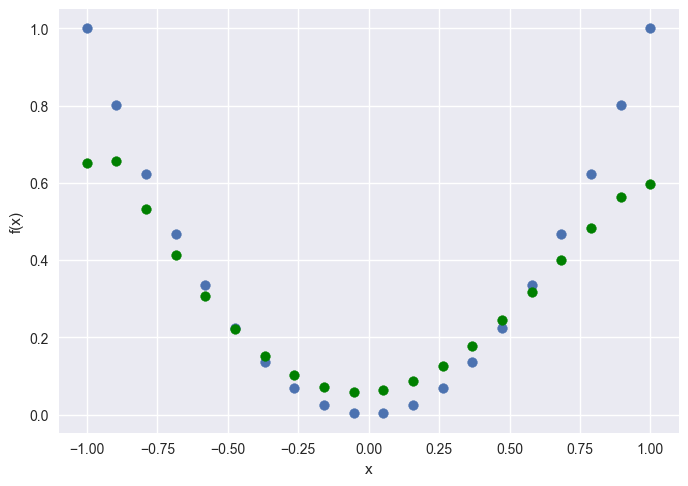

In [28]:
# x_pred = np.linspace(-1, 1, 20)
# predictions = [circuit(x_pred, var) for x_ in x_pred]
savedir = "/Users/soyoung/Documents/works/QC/QCL/qcl/store/"
plt.figure()
plt.scatter(X, Y)
# plt.scatter(x_init, x_init, color="yellow")
plt.scatter(x_pred, predictions[0], color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.savefig(savedir+"fig3a_inputUYonly.png")
plt.show()

### Fig3.c

In [29]:
def sineftn(x):
    output=[]
    for idx in range(x.shape[0]):
        output.append(math.sin(x[idx]*math.pi))
    return np.array(output)

# sineftn(X_range)

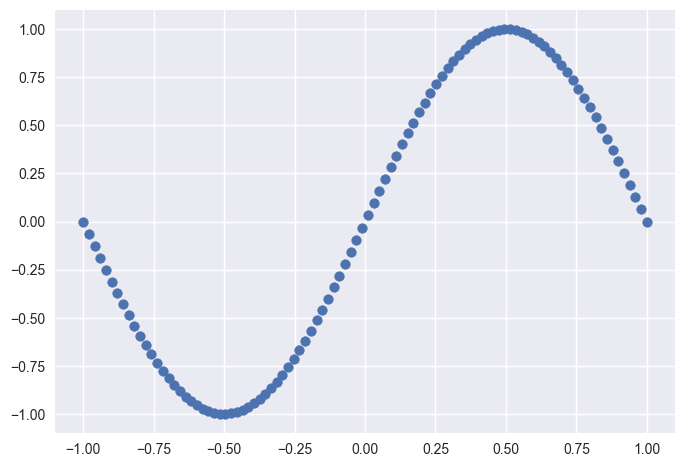

In [30]:
X_range = np.linspace(-1.0,1.0,100)
# X_data = np.stack([X_range, math.e**(X_range)],axis=1)
X_data = np.stack([X_range, sineftn(X_range)],axis=1)
X_data[:,0]
X = np.array(X_data[:,0], requires_grad=False)
Y = np.array(X_data[:,1], requires_grad=False)
# cm_bright = ListedColormap(['#FF0000', '#0000FF'])
# plt.scatter(X, y, c=y, cmap=cm_bright, edgecolors='k')
plt.scatter(X,Y)

In [33]:
n_qubits = 6
depth = 6

In [34]:
combi = 15
initial_theta = np.random.uniform(0.0, 2*np.pi, size=3*n_qubits*depth)
random_aj = np.random.uniform(-1,1,size=n_qubits)
# random_aj = np.zeros_like(random_aj)
random_jjk = np.random.uniform(-1,1,size=combi)
# random_jjk = np.zeros_like(random_jjk)
coeff_jjk = np.zeros((n_qubits, n_qubits-1))
for j in range(n_qubits):
    for k in range(j):
        coeff_jjk[j,k] = random_jjk[j+k]
# print(coeff_jjk.shape)

In [35]:
# coeff_jjk
random_aj

tensor([-0.59459579,  0.27582333,  0.54170597, -0.13083691, -0.32858371,
         0.65070163], requires_grad=True)

In [36]:
initial_theta = initial_theta.reshape(3,n_qubits,depth)

In [31]:
dev = qml.device('default.qubit', wires=n_qubits)
# def Uin(x):
#     for xs in x:
#         for j in range(n_qubits):
#             qml.RZ(np.arccos(xs**2), wires=j) * qml.RY(np.arcsin(xs), wires=j)
def Uin(x):
    for j in range(n_qubits):
        qml.RY(np.arcsin(x), wires=j)
#         qml.RZ(np.arccos(x**2), wires=j) * qml.RY(np.arcsin(x), wires=j)

def hamltn(coeffA, coeffJ):
    part1 = 0
    part2 = 0
    for j in range(n_qubits):
        # coeffA[j] * qml.PauliX(j)
        temp1 = coeffA[j] * qml.PauliX(j)
        part1 += temp1

    for j in range(n_qubits):
        for k in range(j):
            # coeffJ[j,k]* qml.PauliZ(j) @ qml.PauliZ(k)
            temp2 = coeffJ[j,k]* qml.PauliZ(j) @ qml.PauliZ(k)
            part2 += temp2

    hamiltonian = part1 + part2
    return hamiltonian


def Uth(theta):
    for i in range(depth):                  
        qml.ApproxTimeEvolution(hamltn(random_aj, coeff_jjk), 10, 1)
        for j in range(n_qubits):
            rj = n_qubits-j-1
            # rj = j
            qml.RX(theta[0,rj,i],wires=j)
            qml.RZ(theta[1,rj,i],wires=j)
            qml.RX(theta[2,rj,i],wires=j)
# RX(phi, wires, do_queue=True, id=None)[source]¶
weights = initial_theta
# # 
@qml.qnode(dev)
def circuit(x,params):
    Uin(x)
    Uth(params)
    return [qml.expval(qml.PauliZ(wires=0))]


print(qml.draw(circuit)(X,weights))


0: ──RY(M0)
1: ──RY(M0)
2: ──RY(M0)
3: ──RY(M0)
4: ──RY(M0)
5: ──RY(M0)

──╭ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──├ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)
──╰ApproxTimeEvolution(0.01,0.24,-0.80,-0.61,-0.77,-0.26,0.07,-0.54,0.09,0.09,0.27,-0.20,0.27,-0.20,0.95,0.21,-0.20,0.95,0.21,-0.15,-0.89,10.00)

───RX(0.74)──RZ(3.85)──RX(0.62)
───RX(2.97)──RZ(1.70)──R

In [32]:
def quad_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p)**2
#         p = (p + 1)/2
#         loss = loss + (l - p)**2
        
    return loss

def cost(var, features, labels):
    preds = [circuit(x, var) for x in features] 
    
    return quad_loss(labels, preds)


In [33]:
step_size = 0.01
opt = AdamOptimizer(step_size, beta1 = 0.9, beta2=0.99)

var = weights

for it in range(50):
    (var, _, _), _cost = opt.step_and_cost(cost, var, X, Y)
    print("Iter: {:5d}  ".format(it))

Iter:     0  
Iter:     1  
Iter:     2  
Iter:     3  
Iter:     4  
Iter:     5  
Iter:     6  
Iter:     7  
Iter:     8  
Iter:     9  
Iter:    10  
Iter:    11  
Iter:    12  
Iter:    13  
Iter:    14  
Iter:    15  
Iter:    16  
Iter:    17  
Iter:    18  
Iter:    19  
Iter:    20  
Iter:    21  
Iter:    22  
Iter:    23  
Iter:    24  
Iter:    25  
Iter:    26  
Iter:    27  
Iter:    28  
Iter:    29  
Iter:    30  
Iter:    31  
Iter:    32  
Iter:    33  
Iter:    34  
Iter:    35  
Iter:    36  
Iter:    37  
Iter:    38  
Iter:    39  
Iter:    40  
Iter:    41  
Iter:    42  
Iter:    43  
Iter:    44  
Iter:    45  
Iter:    46  
Iter:    47  
Iter:    48  
Iter:    49  


In [34]:
x_pred = np.linspace(-1, 1, 100)
predictions = [circuit(x_pred, var) for x_ in x_pred]

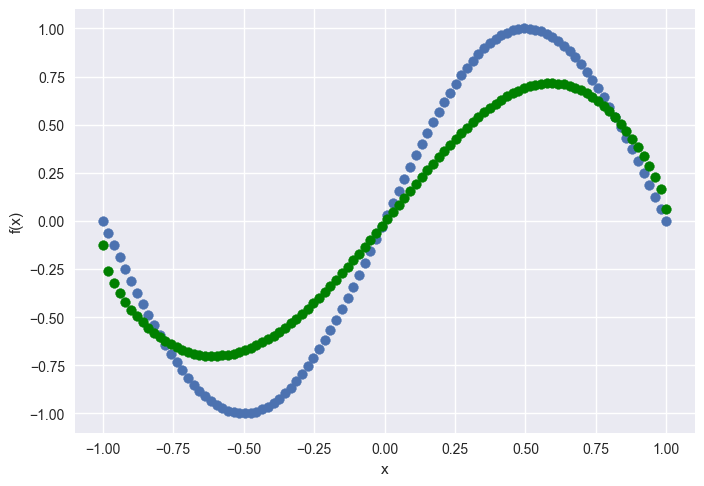

In [36]:
# x_pred = np.linspace(-1, 1, 20)
# predictions = [circuit(x_pred, var) for x_ in x_pred]
savedir = "/Users/soyoung/Documents/works/QC/QCL/qcl/store/"
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions[0], color="green")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.savefig(savedir+"fig3c_100pts_inputUYonly.png")
plt.show()